In [ ]:
!pip install torch
!pip install python-dotenv
!pip install mysqlclient
!pip install --pre deepchem[tensorflow]
!pip install --upgrade scikit-learn

In [43]:
import pandas as pd
import os
import requests
import json
import csv
import io
from collections import defaultdict
from time import time
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sqlalchemy import create_engine
from sqlalchemy import text
import sql
from dotenv import dotenv_values
import deepchem as dc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import seaborn
from matplotlib.pyplot import hist
from sklearn.neighbors import KernelDensity
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
config = dotenv_values('database_URL.env')
url = config['DATABASE_URL']
engine = create_engine(url, echo=False)

# Set disease_id variable for desired disease
#at somepoint include api to chose what disease one wants from : https://www.ebi.ac.uk/efo/
disease_id = "EFO_0005537"

with engine.begin() as conn:
    query = text("SELECT * FROM disease_to_target WHERE disease_id = '{disease_id}';".format(disease_id = disease_id))
    disease_df = pd.read_sql(query, conn)
#displaying the dataframe
display(disease_df)
target_ids = disease_df.sort_values(by = ['association_score'], ascending=False)['target_ensemble_id'].values
#sets target_id to one id instead of several
target_id = target_ids[0] #was previously 1 not 0

In [ ]:
#gets dateframe from planet scale
engine = create_engine(url, echo=False)

with engine.begin() as conn:
    query = text("SELECT * FROM target_to_compounds WHERE target_ensemble_id='{target}';".format(target=target_id))
    target_to_compounds_df = pd.read_sql(query, conn)
#show dataframe
display(target_to_compounds_df)

In [46]:
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [ ]:
# 1. Train Model
print(tf.version.VERSION)

compound_dataset = target_to_compounds_df
smiles = compound_dataset['smiles']
IC50 = compound_dataset['standard_value']
featurizer = dc.feat.ConvMolFeaturizer()
compound_dataset['featurized'] = featurizer.featurize(smiles)
compound_dataset['divided values'] = compound_dataset['standard_value'].astype(float).div(max(compound_dataset['standard_value'].astype(float)))
compound_dataset['pIC50'] = np.log10(compound_dataset['divided values'].astype(float)).mul(-1)
compound_dataset['number'] = list(range(0,len(compound_dataset)))
display(compound_dataset)

training_dataset = compound_dataset.sample(frac = 0.7)
testing_dataset = (compound_dataset[~compound_dataset['number'].isin(training_dataset['number'])])
display(testing_dataset)

numpy_training_dataset = dc.data.NumpyDataset(X=training_dataset['featurized'],y=training_dataset['pIC50'].astype(float), ids=training_dataset['smiles'])
numpy_testing_dataset = dc.data.NumpyDataset(X=testing_dataset['featurized'],y=testing_dataset['pIC50'].astype(float), ids=testing_dataset['smiles'])
display(numpy_training_dataset)
display(numpy_testing_dataset)
#using  the graph convolution model
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2, dense_layer_size=10)
model.fit(numpy_training_dataset, nb_epoch=1)#was 100 on instance

metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(numpy_training_dataset, [metric]))
print("Test set score:", model.evaluate(numpy_testing_dataset, [metric]))
#end of Training the model


#2. Download all compounds in database
with engine.begin() as conn:
    query = text("SELECT compound_id,smiles FROM target_to_compounds;")
    compounds_df = pd.read_sql(query, conn)

predict_list = []
for smile in range(0, len(compounds_df)):
    predict_list.append(None)

compounds_df['predicted_pIC50'] = predict_list

curated_compounds_df = compounds_df.dropna(subset=['smiles'])

new_smiles = curated_compounds_df['smiles']
curated_compounds_df['featurized'] = featurizer.featurize(new_smiles)

#3. run the model to predict ic50 values for each compound in the database
dataset = dc.data.NumpyDataset(X=curated_compounds_df['featurized'], y=curated_compounds_df['predicted_pIC50'], ids=curated_compounds_df['smiles'])
curated_compounds_df['predicted_pIC50'] = model.predict(dataset)

# 4. displays a dataframe that has the following two columns : compound, predicted ic50
display(curated_compounds_df)

In [48]:
# 5. print out the compound that has the highest ic50 value that has NOT been tested on the target already.

curated_compounds_no_target = (curated_compounds_df[~curated_compounds_df['smiles'].isin(target_to_compounds_df['smiles'])])

df = curated_compounds_no_target.sort_values(by = ['predicted_pIC50'], ascending=False)
df.drop_duplicates(subset = 'smiles', inplace = True)

display(df)
compound_ids = df['compound_id'].values
compound_smiles = df['smiles'].values

compound_ids_and_smiles = list(zip(compound_ids, compound_smiles))
best_compound = (compound_ids_and_smiles[0])

# 6. get InChI key for top compound and generate a url for Zinc

url = "https://cactus.nci.nih.gov/chemical/structure/{smiles}/stdinchikey".format(smiles = best_compound[1])
r = requests.get(url=url)
raw_inchikey = r.text
inchikey = raw_inchikey.split('=')[1]

print(inchikey)
#zinc website was not working when we checked last
zinc_url = 'https://zinc15.docking.org/substances/?inchikey={inchikey}'.format(inchikey = inchikey)
print(zinc_url)

,compound_id,smiles,predicted_pIC50,featurized
7861,CHEMBL226744,Cc1n[nH]c2ccc(-c3cncc(OC[C@@H](N)Cc4ccc5c(c4)O...,0.284214,<deepchem.feat.mol_graphs.ConvMol object at 0x...
10055,CHEMBL1773572,CC(=O)Nc1nc2ccc(-c3ccnc(NC(C)(C)c4ccccc4)n3)cc2s1,0.278075,<deepchem.feat.mol_graphs.ConvMol object at 0x...
11717,CHEMBL3970129,NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc([N+](...,0.256418,<deepchem.feat.mol_graphs.ConvMol object at 0x...
11839,CHEMBL363339,CS(=O)(=O)Nc1ccc(Oc2ccc(-c3nc4cc(C(N)=O)ccc4[n...,0.253558,<deepchem.feat.mol_graphs.ConvMol object at 0x...
11663,CHEMBL3909679,NC(=O)c1ccc2[nH]c(-c3ccc(NS(=O)(=O)c4ccc(Cl)c(...,0.250747,<deepchem.feat.mol_graphs.ConvMol object at 0x...
...,...,...,...,...
1927,CHEMBL4790749,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@...,-1.342844,<deepchem.feat.mol_graphs.ConvMol object at 0x...
8432,CHEMBL577375,CCC1C(=O)Nc2ccc(-c3cncc(OC[C@@H](N)Cc4c[nH]c5c...,-1.379802,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1923,CHEMBL4763905,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)CN)C(=O)N[...,-1.405635,<deepchem.feat.mol_graphs.ConvMol object at 0x...
8051,CHEMBL513019,NCCCC(NC(=O)c1cc(Br)c(-c2ccnc3[nH]ccc23)s1)c1c...,-1.483913,<deepchem.feat.mol_graphs.ConvMol object at 0x...


XGYHYTSMABCFHU-KRWDZBQOSA-N
https://zinc15.docking.org/substances/?inchikey=XGYHYTSMABCFHU-KRWDZBQOSA-N


In [49]:
small_df = df.head(10)
dataset = dc.data.NumpyDataset(X=small_df['featurized'],y=small_df['predicted_pIC50'].astype(float), ids=small_df['smiles'])

In [50]:
just_smiles_df = pd.DataFrame()
just_smiles_df['smiles'] = small_df['smiles']
smiles = just_smiles_df['smiles'].tolist
small_smiles = just_smiles_df.head(10)
just_smiles_df['name'] = just_smiles_df['smiles']
just_smiles_df.to_csv('smiles.csv', index = False)

In [51]:
#making the smiles dataframe
smiles = small_df['smiles']
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation = True)
small_df['frag_featurized'] = featurizer.featurize(smiles)
display(small_df)

/usr/local/lib/python3.10/dist-packages/deepchem/feat/base_classes.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)
<ipython-input-51-f9395275f268>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['frag_featurized'] = featurizer.featurize(smiles)


,compound_id,smiles,predicted_pIC50,featurized,frag_featurized
7861,CHEMBL226744,Cc1n[nH]c2ccc(-c3cncc(OC[C@@H](N)Cc4ccc5c(c4)O...,0.284214,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
10055,CHEMBL1773572,CC(=O)Nc1nc2ccc(-c3ccnc(NC(C)(C)c4ccccc4)n3)cc2s1,0.278075,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
11717,CHEMBL3970129,NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc([N+](...,0.256418,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
11839,CHEMBL363339,CS(=O)(=O)Nc1ccc(Oc2ccc(-c3nc4cc(C(N)=O)ccc4[n...,0.253558,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
11663,CHEMBL3909679,NC(=O)c1ccc2[nH]c(-c3ccc(NS(=O)(=O)c4ccc(Cl)c(...,0.250747,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
11638,CHEMBL195177,NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Cl)c(...,0.250357,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
11736,CHEMBL3971843,NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Cl)cc...,0.249573,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
12060,CHEMBL3973311,NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(N5CCO...,0.246491,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
11689,CHEMBL195846,NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Cl)cc...,0.243262,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
11730,CHEMBL3933192,NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Br)cc...,0.243262,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...


In [52]:
frag_dataset = dc.data.NumpyDataset(X=small_df['frag_featurized'], y = None, w = None, ids = dataset.ids)

tr = dc.trans.FlatteningTransformer(frag_dataset) # flatten dataset and add ids to each fragment
frag_dataset = tr.transform(frag_dataset)

In [53]:
# whole molecules
pred = model.predict(dataset)
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convenience
display(pred)
# fragments
pred_frags = model.predict(frag_dataset)
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])  # turn to dataframe for convenience

print(pred_frags)
# merge 2 dataframes by molecule names
mol_df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
mol_df['Contrib'] = mol_df["Molecule"] - mol_df["Fragment"]
display(mol_df)

,Molecule
Cc1n[nH]c2ccc(-c3cncc(OC[C@@H](N)Cc4ccc5c(c4)OC(F)(F)C(F)(F)O5)c3)cc12,0.284214
CC(=O)Nc1nc2ccc(-c3ccnc(NC(C)(C)c4ccccc4)n3)cc2s1,0.278075
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc([N+](=O)[O-])cc4)cc3)nc2c1,0.256418
CS(=O)(=O)Nc1ccc(Oc2ccc(-c3nc4cc(C(N)=O)ccc4[nH]3)cc2)cc1,0.253558
NC(=O)c1ccc2[nH]c(-c3ccc(NS(=O)(=O)c4ccc(Cl)c(Cl)c4)cc3)nc2c1,0.250747
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Cl)c(Cl)c4)cc3)nc2c1,0.250357
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Cl)cc4Cl)cc3)nc2c1,0.249573
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(N5CCOCC5)cc4)cc3)nc2c1,0.246491
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Cl)cc4)cc3)nc2c1,0.243262
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Br)cc4)cc3)nc2c1,0.243262


                                                    Fragment
Cc1n[nH]c2ccc(-c3cncc(OC[C@@H](N)Cc4ccc5c(c4)OC...  0.227720
Cc1n[nH]c2ccc(-c3cncc(OC[C@@H](N)Cc4ccc5c(c4)OC...  0.244281
Cc1n[nH]c2ccc(-c3cncc(OC[C@@H](N)Cc4ccc5c(c4)OC...  0.261577
Cc1n[nH]c2ccc(-c3cncc(OC[C@@H](N)Cc4ccc5c(c4)OC...  0.182870
Cc1n[nH]c2ccc(-c3cncc(OC[C@@H](N)Cc4ccc5c(c4)OC...  0.244281
...                                                      ...
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Br)cc4... -0.037006
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Br)cc4...  0.157032
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Br)cc4... -0.113524
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Br)cc4...  0.236394
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc(Br)cc4... -0.005265

[307 rows x 1 columns]


,Fragment,Molecule,Contrib
CC(=O)Nc1nc2ccc(-c3ccnc(NC(C)(C)c4ccccc4)n3)cc2s1,0.273023,0.278075,0.005051
CC(=O)Nc1nc2ccc(-c3ccnc(NC(C)(C)c4ccccc4)n3)cc2s1,0.094243,0.278075,0.183832
CC(=O)Nc1nc2ccc(-c3ccnc(NC(C)(C)c4ccccc4)n3)cc2s1,0.015045,0.278075,0.263030
CC(=O)Nc1nc2ccc(-c3ccnc(NC(C)(C)c4ccccc4)n3)cc2s1,-0.116537,0.278075,0.394612
CC(=O)Nc1nc2ccc(-c3ccnc(NC(C)(C)c4ccccc4)n3)cc2s1,0.157281,0.278075,0.120793
...,...,...,...
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc([N+](=O)[O-])cc4)cc3)nc2c1,0.050614,0.256418,0.205804
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc([N+](=O)[O-])cc4)cc3)nc2c1,0.183224,0.256418,0.073194
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc([N+](=O)[O-])cc4)cc3)nc2c1,-0.357854,0.256418,0.614272
NC(=O)c1ccc2[nH]c(-c3ccc(S(=O)(=O)Nc4ccc([N+](=O)[O-])cc4)cc3)nc2c1,0.183224,0.256418,0.073194


In [54]:
def vis_contribs(mols, df, smi_or_sdf = "smi"):
    # input format of file, which was used to create dataset determines the order of atoms,
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            print(mol)
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]

        if smi_or_sdf == "sdf":
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt))
    return maps

In [55]:
mols = [m for m in Chem.SmilesMolSupplier('smiles.csv', ',') if m is not None]
print(mols)

[<rdkit.Chem.rdchem.Mol object at 0x799fb7fb4660>, <rdkit.Chem.rdchem.Mol object at 0x799fb7fb4a50>, <rdkit.Chem.rdchem.Mol object at 0x799fb7fb6490>, <rdkit.Chem.rdchem.Mol object at 0x799fb7fb6b90>, <rdkit.Chem.rdchem.Mol object at 0x799fb7fb5310>, <rdkit.Chem.rdchem.Mol object at 0x799fb7fb4c80>, <rdkit.Chem.rdchem.Mol object at 0x799fb7fb5e70>, <rdkit.Chem.rdchem.Mol object at 0x799fb7fb5230>, <rdkit.Chem.rdchem.Mol object at 0x799fb7fb6d50>, <rdkit.Chem.rdchem.Mol object at 0x799fb7fb6ce0>]


[<Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>]

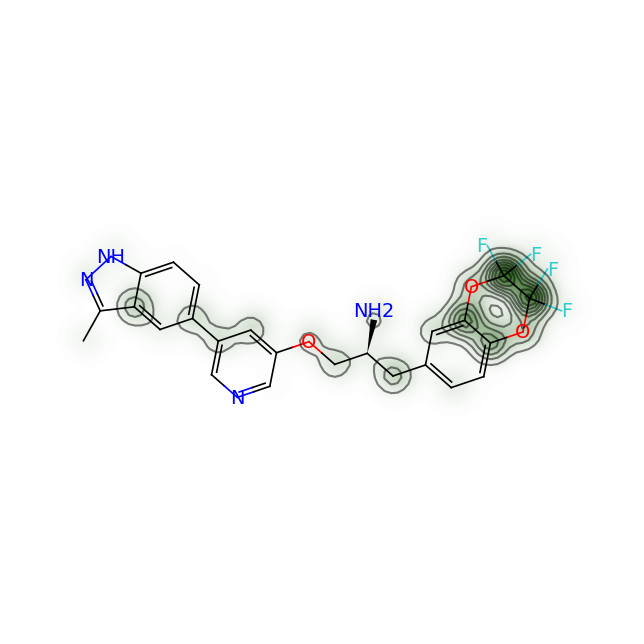

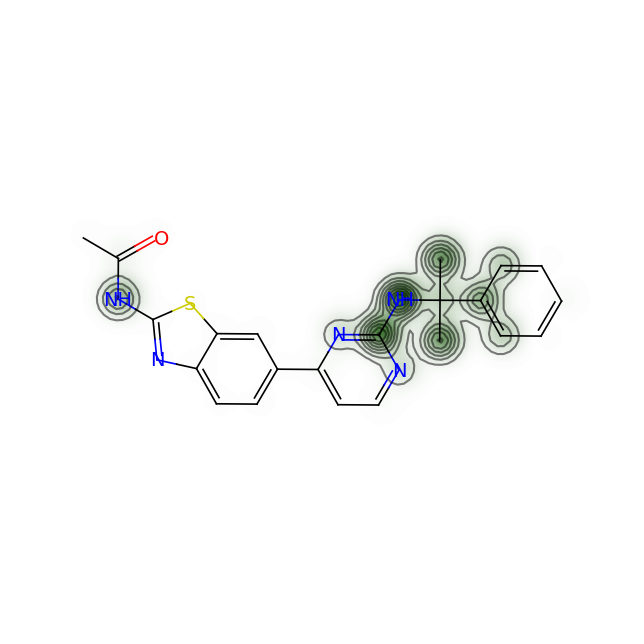

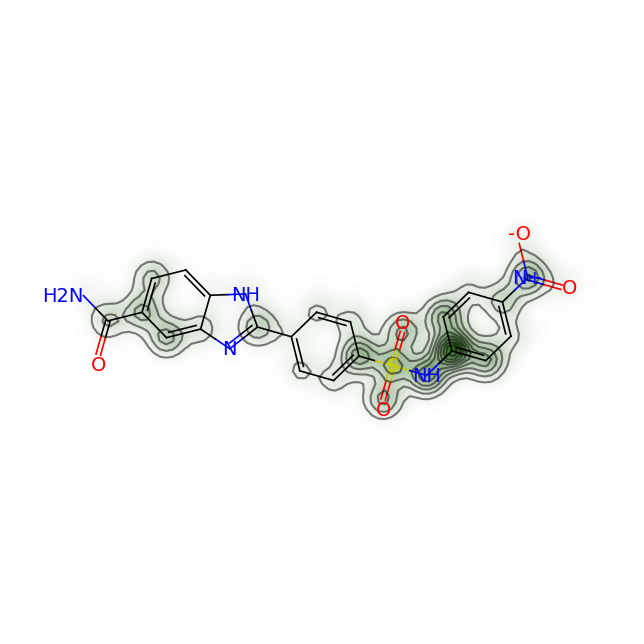

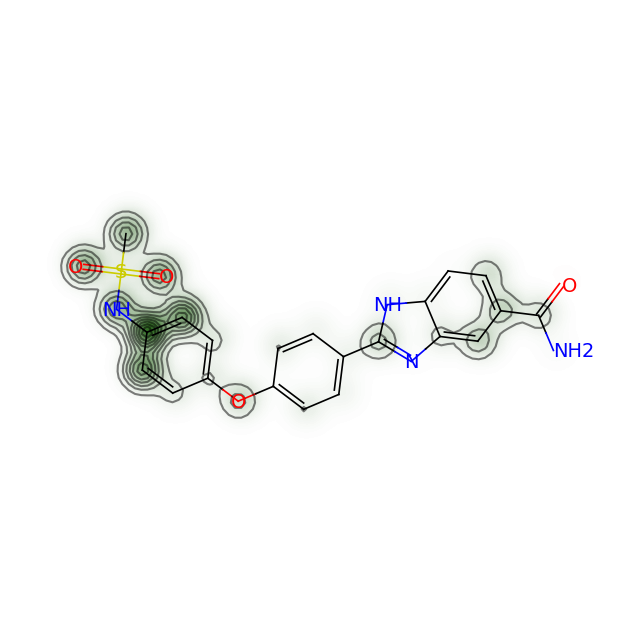

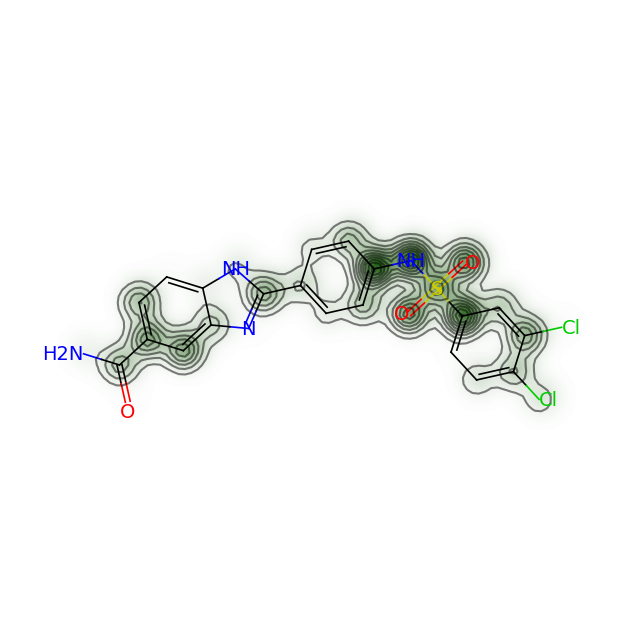

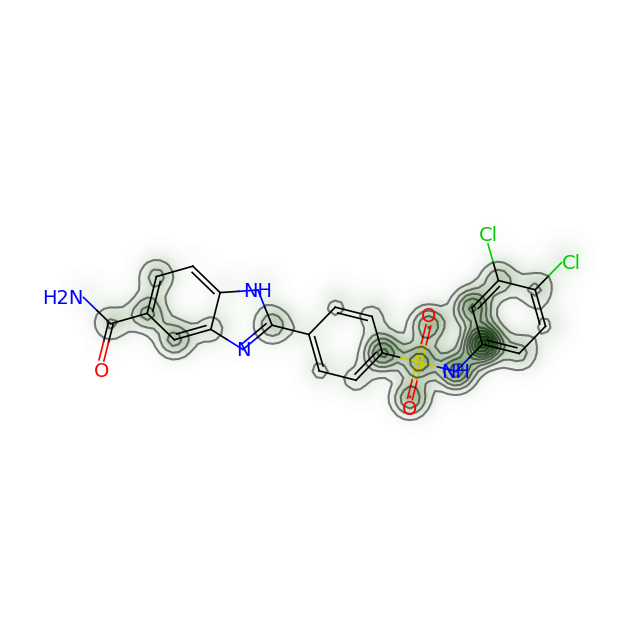

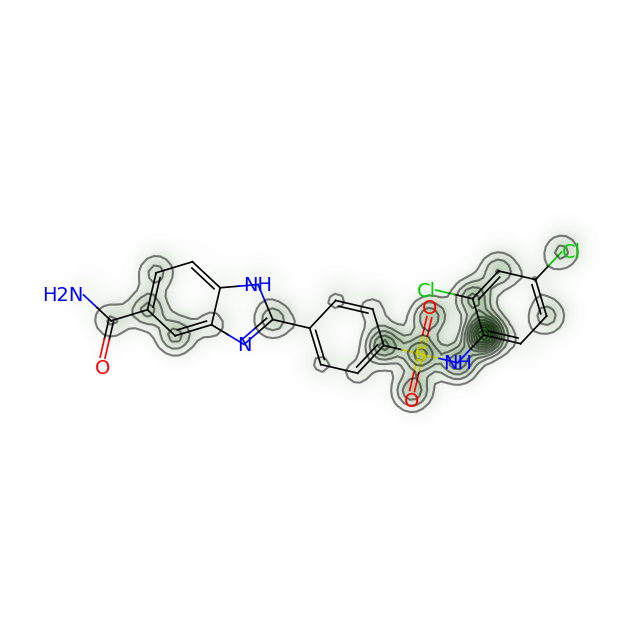

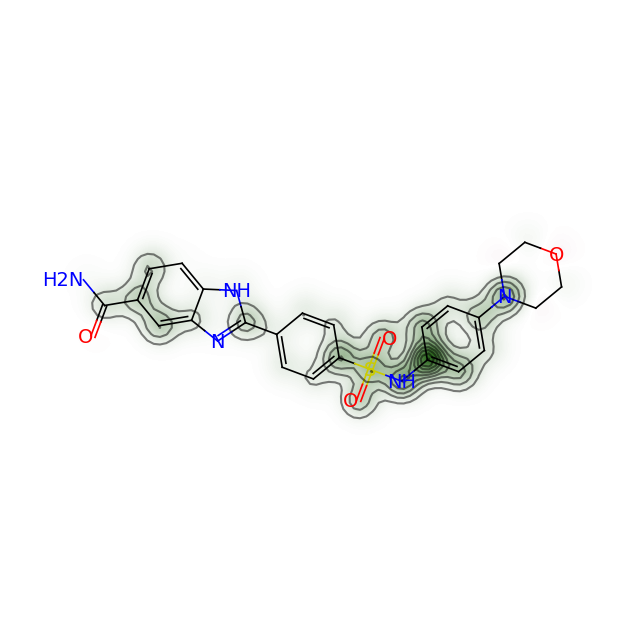

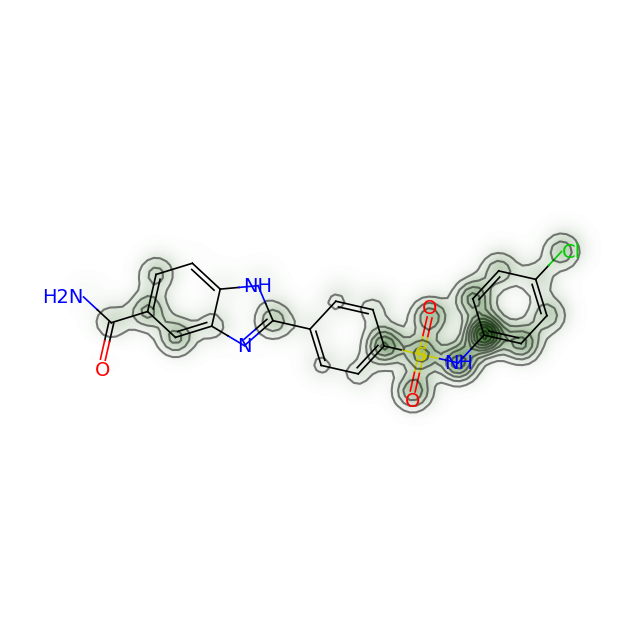

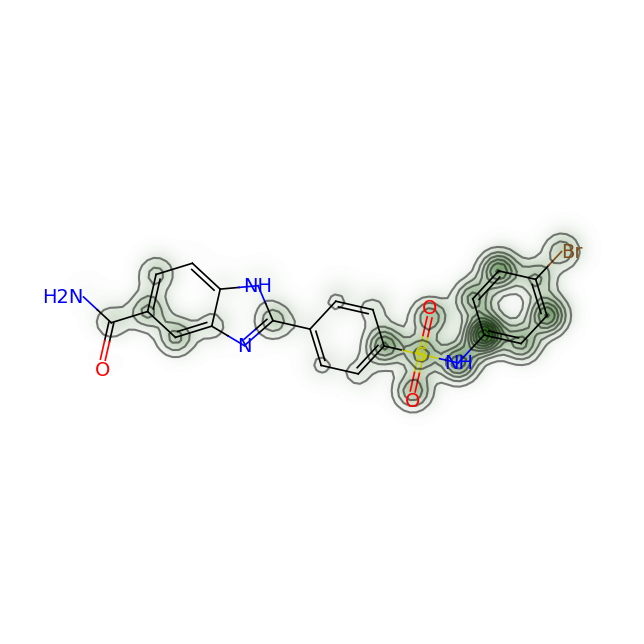

In [56]:
vis_contribs(mols, mol_df, 'smi')

In [57]:


model.save_checkpoint()


,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id
0,0,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,IC50,12000.0,CHEMBL3377973,B,In vitro inhibition of purified recombinant Mr...,CHEMBL3352588,"During the last decade, the use of small molec...",ENSG00000020922
1,1,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,IC50,66000.0,CHEMBL3377972,B,Inhibition of Mre11 exonuclease activity (unkn...,CHEMBL3352588,"During the last decade, the use of small molec...",ENSG00000020922
2,0,CHEMBL4128424,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,IC50,2890.0,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
3,1,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,4590.0,CHEMBL4259781,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230
4,2,CHEMBL4127437,COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc...,IC50,6130.0,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
...,...,...,...,...,...,...,...,...,...,...,...
13747,995,CHEMBL7976,O=C(/C=C/c1ccccc1)c1ccccc1,IC50,620000.0,CHEMBL4307262,B,Inhibition of tubulin polymerization (unknown ...,CHEMBL4304785,"Curcumin (CU), an edible natural pigment from ...",ENSG00000261456
13748,996,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,800000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456
13749,997,CHEMBL18869,COc1cccc(-c2nc(O)c3cc(OC)ccc3n2)c1,IC50,4900000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456
13750,998,CHEMBL278647,COc1cccc(-c2nc(O)c3cc(OC)c(OC)cc3n2)c1,IC50,6500000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456


largest cluster: Cluster 0, Size: 418
Cluster 0: The global pandemic of drug-sensitive cancers and the increasing threat from drug-resistant cancers make an urgent need to develop more effective anti-cancer candidates. Quinolone derivatives possess promising anti-cancer activity, and some of them have already been approved to treat cancers or under clinical trials. Hybridization of quinolone with other anti-cancer pharmacophores may provide more efficient anti-cancer candidates, so quinolone hybrids worth to be investigated. In this review, the recent advances in the development of novel quinolone hybrids as potential anti-cancer agents are highlighted, and the structure-activity relationship is also discussed to provide an insight for further development of more active quinolone hybrids.
Cluster 1: A series of 3,4-disubstituted piperidine derivatives were obtained based on a conformational restriction strategy and a lead compound, <b>A12</b>, that exhibited potent in vitro and in vivo

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


1247
1247
False
Structure-based design and synthesis of the 3,4'-bispyridinylethylene series led to the discovery of 3-isoquinolinylpyridine 13a as a potent PKB/Akt inhibitor with an IC(50) of 1.3nM against Akt1. Compound 13a shows excellent selectivity against distinct families of kinases such as tyrosine kinases and CAMK, and displays poor to marginal selectivity against closely related kinases in the AGC and CMGC families. Moreover, 13a demonstrates potent cellular activity comparable to staurosporine, with IC(50) values of 0.42 and 0.59microM against MiaPaCa-2 and the Akt1 overexpressing FL5.12-Akt1, respectively. Inhibition of phosphorylation of the Akt downstream target GSK3 was also observed in FL5.12-Akt1 cells with an EC(50) of 1.5microM. The X-ray structures of 12 and 13a in complex with PKA in the ATP-binding site were determined.


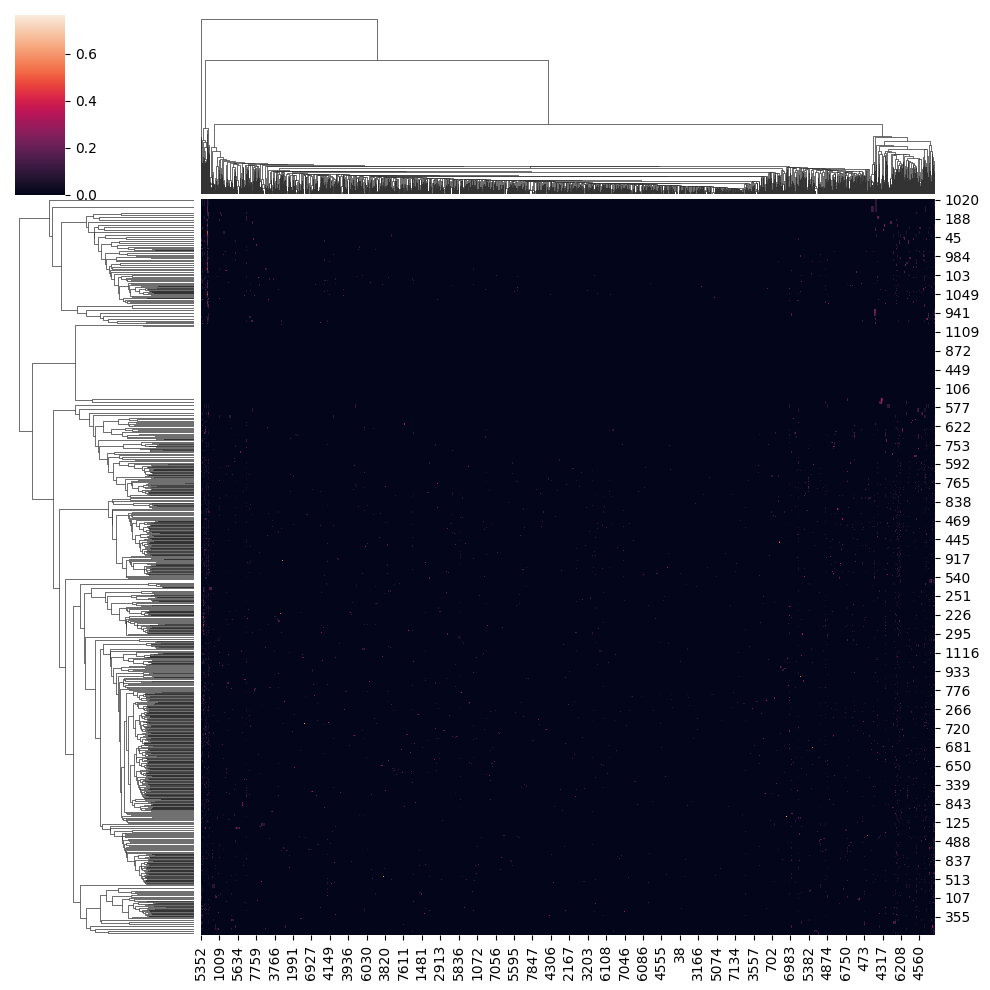

In [58]:
"""
insert code here that
1. retrieves the terms for all the assays that are relevant to the target the user picked.
2. clusters the assays according to their descriptive terms
3. plots the clusters (set n_clusters = 10)
4. prints out the title of one assay from each cluster.
"""
#getting information from the database
config = dotenv_values("database_URL.env")
url = config['DATABASE_URL']
engine = create_engine(url, echo=False)

with engine.begin() as conn:
    query = text("select * from target_to_compounds;")
    target_list = pd.read_sql(query, conn)
display(target_list)


three_col_list = target_list[['assay_id', 'assay_description', 'abstract']].copy()
#getting just the Assay descriptions to prep for clustering
unique_list = []
for index, row in three_col_list.iterrows():
    if (row["assay_id"], row["assay_description"], row["abstract"]) in unique_list:
        continue
    else:
        unique_list.append((row["assay_id"], row["assay_description"], row["abstract"]))

Assay_Descriptions = [abstract for (assay_ids, assay_name, abstract) in unique_list]
Assay_Descriptions_Joined = ':: '.join(Assay_Descriptions)
#making the descriptions into one list
Assay_Descriptions_List = Assay_Descriptions
#the countVectorizer needed for the other vectorizer
Assay_Count_Vect = CountVectorizer()
Assay_Train_Counts = Assay_Count_Vect.fit_transform(Assay_Descriptions_List)
n_clusters = 20
X = Assay_Train_Counts.toarray()
#the second vectorizier (tfidf transformer)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(Assay_Train_Counts)
tf_idf_vector = tfidf_transformer.transform(Assay_Train_Counts)

ward = AgglomerativeClustering(
    n_clusters = n_clusters, linkage="ward", connectivity=None, compute_full_tree= True,compute_distances= True
)
ward.fit(X)

unique_labels, counts = np.unique(ward.labels_, return_counts=True)
cluster_sizes = dict(zip(unique_labels, counts))

largest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)
largest_cluster_size = cluster_sizes[largest_cluster_label]

print(f"largest cluster: Cluster {largest_cluster_label}, Size: {largest_cluster_size}")

cluster_labels = ward.fit_predict(tf_idf_vector.toarray())

cluster_assay_descriptions = {}
for cluster_label, assay_description in zip(cluster_labels, Assay_Descriptions):
    if cluster_label not in cluster_assay_descriptions:
        cluster_assay_descriptions[cluster_label] = []
    cluster_assay_descriptions[cluster_label].append(assay_description)

sorted_clusters = sorted(cluster_assay_descriptions.keys())
#getting and showing the cluster labels
for cluster_label in sorted_clusters:
    assay_descriptions = cluster_assay_descriptions[cluster_label]
    print(f"Cluster {cluster_label}: {assay_descriptions[0]}")

X_Hist = ward.distances_
kernel = stats.gaussian_kde(X_Hist)
print(kernel(X_Hist))

df_idf = pd.DataFrame(tfidf_transformer.idf_,index=Assay_Count_Vect.get_feature_names_out(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'])

count_vector=Assay_Count_Vect.transform(Assay_Descriptions_List)

tf_idf_vector=tfidf_transformer.transform(count_vector)
print(tf_idf_vector)

feature_names = Assay_Count_Vect.get_feature_names_out()

first_document_vector=tf_idf_vector[0]

df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)
#showing the Graph
seaborn.clustermap(tf_idf_vector.toarray(),method='ward')

print(len(cluster_labels))
print(len(Assay_Descriptions))
print(cluster_assay_descriptions[4][0] == cluster_assay_descriptions[4][1])
print(cluster_assay_descriptions[4][9])